In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

batch_size = 64
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [36]:
latent_dim = 100
image_size = 28 * 28
hidden_dim = 256

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, image_size),
            nn.Tanh()  # Виходи в діапазоні [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

In [38]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Виходи в діапазоні [0, 1]
        )

    def forward(self, x):
        return self.model(x)

In [39]:
generator = Generator()
discriminator = Discriminator()

In [40]:
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [43]:
num_epochs = 60

for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Навчання дискримінатора
        optimizer_d.zero_grad()
        real_images = real_images.view(batch_size, -1)
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)
        
        noise = torch.randn(batch_size, latent_dim)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)
        
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()
        
        # Навчання генератора
        optimizer_g.zero_grad()
        outputs_fake = discriminator(fake_images)
        loss_g = criterion(outputs_fake, real_labels)
        loss_g.backward()
        optimizer_g.step()
        
        if (batch_idx+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

Epoch [1/60], Step [100/938], Loss D: 0.8255, Loss G: 1.0618
Epoch [1/60], Step [200/938], Loss D: 1.0872, Loss G: 2.4036
Epoch [1/60], Step [300/938], Loss D: 0.8069, Loss G: 1.7193
Epoch [1/60], Step [400/938], Loss D: 0.9011, Loss G: 1.1872
Epoch [1/60], Step [500/938], Loss D: 0.8542, Loss G: 2.0481
Epoch [1/60], Step [600/938], Loss D: 1.1386, Loss G: 1.8666
Epoch [1/60], Step [700/938], Loss D: 0.9202, Loss G: 0.8145
Epoch [1/60], Step [800/938], Loss D: 0.9391, Loss G: 1.3266
Epoch [1/60], Step [900/938], Loss D: 1.0593, Loss G: 1.4736
Epoch [2/60], Step [100/938], Loss D: 0.8216, Loss G: 1.7451
Epoch [2/60], Step [200/938], Loss D: 0.8322, Loss G: 1.2839
Epoch [2/60], Step [300/938], Loss D: 1.0178, Loss G: 2.1435
Epoch [2/60], Step [400/938], Loss D: 1.0223, Loss G: 1.7644
Epoch [2/60], Step [500/938], Loss D: 0.8412, Loss G: 1.7406
Epoch [2/60], Step [600/938], Loss D: 0.9361, Loss G: 1.4792
Epoch [2/60], Step [700/938], Loss D: 0.9663, Loss G: 1.1225
Epoch [2/60], Step [800/

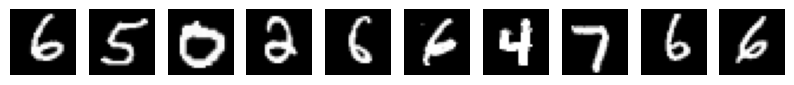

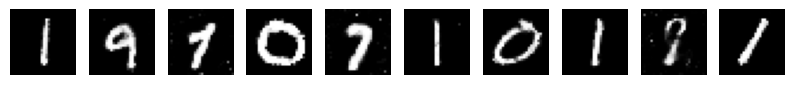

In [45]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

num_samples = 10
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    axes[i].imshow(images[i].squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()

num_samples = 10
noise = torch.randn(num_samples, latent_dim)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()

fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    axes[i].imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()